In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gpaw import GPAW
from ase.io import read, write
from abtem.potentials import Potential
from abtem.dft import GPAWPotential



In [2]:
atoms = read('graphene_hexagonal.cif')

The unit cell for the DFT calculation does not have to be orthogonal, however, the potential has to be made orthogonal. If the `orthogonalize_cell` raises an error abTEM is not able to use the DFT calculation.

We will use minimal hexagonal cell for our graphene DFT calculation.

In [19]:
gpaw = GPAW(h=.1, txt=None, kpts=(4,4,4))
atoms.set_calculator(gpaw)
atoms.get_potential_energy()

-18.468420217107088

In [20]:
gpaw.write('graphene.gpw')

In [3]:
gpaw = GPAW('graphene.gpw', txt=None)

In [4]:


dft_potential = GPAWPotential(gpaw, sampling=.02)
dft_potential = dft_potential.build()

In [23]:
dft_potential

## Comparing DFT to IAM

In [5]:
from abtem.structures import orthogonalize_cell
atoms = orthogonalize_cell(gpaw.atoms)

iam_potential = Potential(atoms, sampling=.02).build()

In [39]:
projected_iam = iam_potential.array.sum(0)
projected_iam -= projected_iam.min()

projected_dft = dft_potential.array.sum(0)
projected_dft -= projected_dft.min()

absolute_difference = projected_iam - projected_dft

valid = np.abs(projected_iam) > 1
relative_difference = np.zeros_like(projected_iam)
relative_difference[:] = np.nan
relative_difference[valid] = (projected_iam[valid] - projected_dft[valid]) / projected_iam[valid]

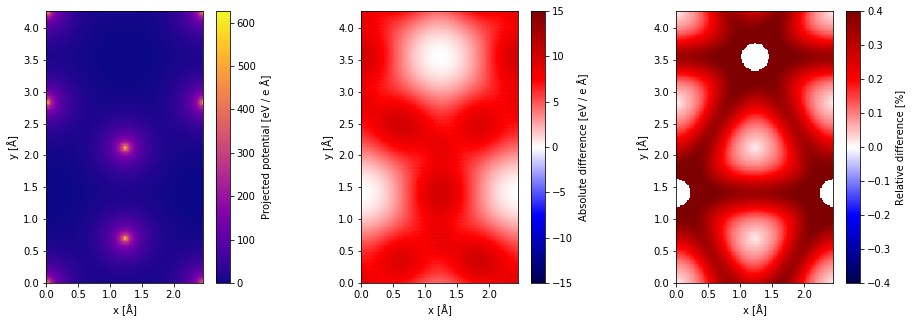

In [58]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

extent = [0, dft_potential.extent[0], 0, dft_potential.extent[1]]

im1 = ax1.imshow(projected_dft.T, cmap='plasma', extent=extent)
im2 = ax2.imshow(absolute_difference.T, vmin=-15, vmax=15, cmap='seismic', extent=extent)
im3 = ax3.imshow(relative_difference.T, vmin=-.4, vmax=.4, cmap='seismic', extent=extent)

labels = ('Projected potential [eV / e Å]', 'Absolute difference [eV / e Å]', 'Relative difference [%]')

for ax, im, label in zip((ax1, ax2, ax3), (im1, im2, im3), labels):
    ax.set_xlabel('x [Å]')
    ax.set_ylabel('y [Å]')
    
    fig.colorbar(im, ax=ax, label=label)